# Linear Regression with stratified sampling

Try to apply a linear regression model to the merged otu table

In [1]:
import csv
import logging

import biom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from src import project_directory
from src.database import get_session, Sample, Dataset

In [ ]:
session = get_session()
logging.basicConfig()
logging.getLogger('sqlalchemy.engine.Engine').setLevel(logging.ERROR)

Ok simply load otu table and then add tissue as metadata:

In [3]:
biom_file = project_directory / "merged_results/export/table/feature-table.biom"
table = biom.load_table(biom_file)

In [4]:
# Get the list of samples in the OTU table
samples = table.ids(axis='sample')
print(samples[:10])

['H_10_S10_L001' 'H_11_S11_L001' 'H_12_S12_L001' 'H_13_S13_L001'
 'H_14_S14_L001' 'H_15_S15_L001' 'H_16_S16_L001' 'H_17_S17_L001'
 'H_18_S18_L001' 'H_19_S19_L001']


In [5]:
# Query the database for samples in the samples list and collect the tissue
queried_samples = session.query(Sample).filter(Sample.sample_id.in_(samples)).all()
sample2tissue = {sample.sample_id: sample.dataset.tissue for sample in queried_samples}
sample2dataset = {sample.sample_id: sample.dataset_id for sample in queried_samples}

In [6]:
# Create an empty dataframe with the same indices as the samples
metadata = pd.DataFrame(index=samples)

# Add the tissue as new metadata
metadata['tissue'] = metadata.index.map(sample2tissue)
metadata['dataset'] = metadata.index.map(sample2dataset)

# Update the OTU table with the new metadata
table.add_metadata(metadata.to_dict(orient='index'), axis='sample')

# Verify that the tissue has been added correctly
print(table.metadata(axis='sample')[0])

defaultdict(<function Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda> at 0x7f30f40bbaf0>, {'tissue': 'hindgut', 'dataset': 3})


Transform the otu table to a pandas dataframe and then add the tissue as metadata.
Table should be transposed to have samples as rows and otus as columns.

In [7]:
# Convert the OTU table to a dataframe
otu_df = pd.DataFrame(table.matrix_data.toarray(), index=table.ids(axis='observation'), columns=table.ids(axis='sample'))

# Add the tissue metadata as a new column
otu_df = otu_df.transpose()
otu_df['tissue'] = otu_df.index.map(sample2tissue)
otu_df['dataset'] = otu_df.index.map(sample2dataset)

Inspect the create dataframe:

In [8]:
otu_df[['tissue', 'dataset']].head()

,tissue,dataset
H_10_S10_L001,hindgut,3
H_11_S11_L001,hindgut,3
H_12_S12_L001,hindgut,3
H_13_S13_L001,hindgut,3
H_14_S14_L001,hindgut,3


In [9]:
otu_df["tissue"].value_counts()

tissue
milk       379
hindgut    141
rumen      118
Name: count, dtype: int64

Transform tables:

In [10]:
groups = otu_df["dataset"]
X = otu_df.drop(columns=["tissue", "dataset"])
y = otu_df["tissue"]

So the point is that we have 6 datasets for 3 tissues: if I simply divide the dataset using `train_test_split, I will have in test set samples from the same dataset of the training set: this could be a data leakage. So let's try to split the dataset in
order to not have samples in the test set from the same dataset of the training set:

In [ ]:
gss = GroupShuffleSplit(test_size=0.5, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

A test of groups:

In [12]:
train_groups = []
test_groups = []

for group in set(groups.iloc[train_idx]):
    group = int(group)
    dataset = session.query(Dataset).filter(Dataset.id == group).one()
    train_groups.append((group, dataset.tissue, dataset.project))
print("train groups:", train_groups)

for group in set(groups.iloc[test_idx]):
    group = int(group)
    dataset = session.query(Dataset).filter(Dataset.id == group).one()
    test_groups.append((group, dataset.tissue, dataset.project))
print("test groups:", test_groups)


train groups: [(13, 'hindgut', 'RABOLA'), (14, 'rumen', 'RABOLA'), (15, 'milk', 'RABOLA')]
test groups: [(16, 'milk', 'RABOLA'), (2, 'rumen', 'FARM-INN'), (3, 'hindgut', 'FARM-INN')]


Ok, now create train and test set relyin on indexes:

In [13]:
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

## Creating a model

In [14]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [ ]:
model = LogisticRegression(solver="liblinear", max_iter=1000)
ovr_classifier = OneVsRestClassifier(model)

In [ ]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}

In [ ]:
grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=-1, verbose=1, cv=5)

In [18]:
grid_search.fit(scaled_X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             verbose=1)

In [ ]:
grid_search.best_params_

{'C': 1, 'penalty': 'l1'}

In [ ]:
y_pred = grid_search.predict(scaled_X_test)

In [21]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.9452554744525548
Classification Report:
              precision    recall  f1-score   support

     hindgut       1.00      0.73      0.85        56
        milk       0.91      1.00      0.96       160
       rumen       1.00      1.00      1.00        58

    accuracy                           0.95       274
   macro avg       0.97      0.91      0.93       274
weighted avg       0.95      0.95      0.94       274



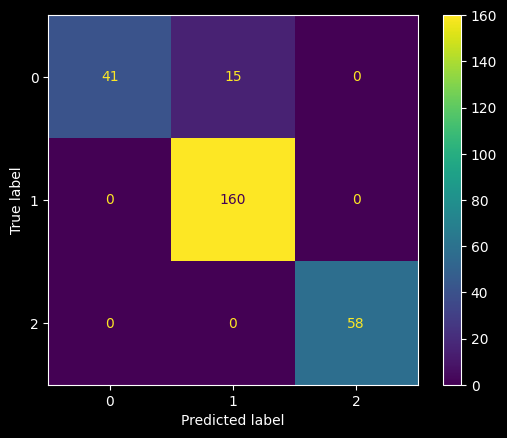

In [22]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Get the best model and save it to a file:

In [23]:
best_model = grid_search.best_estimator_
joblib.dump(best_model, project_directory / "notebooks/logistic_regression_model.pkl")

['/home/cozzip/deep_micro_core/notebooks/logistic_regression_model.pkl']

Now try to collect the coefficients to identify the features that are more important for the model.

In [24]:
coefficients = best_model.coef_[0]
feature_importance = pd.DataFrame({'Feature ID': X.columns, 'Coefficient': coefficients})
feature_importance['Importance'] = np.abs(feature_importance['Coefficient'])
feature_importance.set_index('Feature ID', inplace=True)
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
feature_importance.head(10)

,Coefficient,Importance
Feature ID,,
a41afac2212797bae138bb82c0a6e81d,0.353792,0.353792
31a3429705672357d6e8791cc0f77794,0.316309,0.316309
479e6d25736150eb5f2dfef3f3f993ac,0.299861,0.299861
9688f7cbd057b6f5396268aa7dec3038,0.291910,0.291910
ea7d53b36bda3eaeefb0f99d9963cc43,0.280449,0.280449
d110eaf206cfa20b1d8f7eb387c0f56d,0.263738,0.263738
a2fbe9519c741cbd30f08567fe3e2ef8,0.225626,0.225626
118753b46900f07900a94c5472e535d5,0.210934,0.210934
e455e29ae32148a0e50525b9613124dd,0.202913,0.202913


try to load the taxononies from file

In [25]:
taxonomy_file = project_directory / "merged_results/export/taxonomy/taxonomy.tsv"

with open(taxonomy_file, 'r') as handle:
    reader = csv.DictReader(handle, delimiter='\t')
    taxonomies = [row for row in reader]

taxonomies = {row['Feature ID']: row["Taxon"] for row in taxonomies}
taxonomies = {key: value.split(";")[:-1] for key, value in taxonomies.items()}
taxonomies = pd.DataFrame.from_dict(taxonomies, orient='index', columns=[f"Level_{i}" for i in range(1, 9)])
taxonomies.index.name = "Feature ID"
taxonomies.head()

,Level_1,Level_2,Level_3,Level_4,Level_5,Level_6,Level_7,Level_8
Feature ID,,,,,,,,
00005da053b2c7b99c1f46889cbd7d33,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodospirillales,,,,
000064ab480f315e268221d5ee0f9297,Bacteria,Firmicutes,Negativicutes,Veillonellales-Selenomonadales,Selenomonadaceae,Anaerovibrio,,
0000e116cc2f5406e876821a7c052ded,Bacteria,Chloroflexi,Chloroflexia,Chloroflexales,Roseiflexaceae,,,
0002114dfc1325eafec7bed8250435ea,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,,,,
0002b1df012f092104af19e6cdb26d85,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotellaceae UCG-004,,


In [26]:
merged_df = feature_importance.merge(taxonomies, left_index=True, right_index=True, how="inner")
merged_df.to_csv(project_directory / "notebooks/feature_importance.csv", index=False)
merged_df.head()

,Coefficient,Importance,Level_1,Level_2,Level_3,Level_4,Level_5,Level_6,Level_7,Level_8
Feature ID,,,,,,,,,,
a41afac2212797bae138bb82c0a6e81d,0.353792,0.353792,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,,
31a3429705672357d6e8791cc0f77794,0.316309,0.316309,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,,
479e6d25736150eb5f2dfef3f3f993ac,0.299861,0.299861,Bacteria,Firmicutes,Clostridia,Oscillospirales,UCG-010,,,
9688f7cbd057b6f5396268aa7dec3038,0.291910,0.291910,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,,
ea7d53b36bda3eaeefb0f99d9963cc43,0.280449,0.280449,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,,
